# importing libraries

In [1]:
import pandas as pd

#### loading our data

In [12]:
pop = pd.read_csv('Desktop/My_DataScience/state-population.csv')
areas = pd.read_csv('Desktop/My_DataScience/state-areas.csv')
abbrevs = pd.read_csv('Desktop/My_DataScience/state-abbrevs.csv')


##### viewing what our data looks like

In [13]:
print(pop.head())
print(areas.head())
print(abbrevs.head())

  state/region     ages  year  population
0           AL  under18  2012   1117489.0
1           AL    total  2012   4817528.0
2           AL  under18  2010   1130966.0
3           AL    total  2010   4785570.0
4           AL  under18  2011   1125763.0
        state  area (sq. mi)
0     Alabama          52423
1      Alaska         656425
2     Arizona         114006
3    Arkansas          53182
4  California         163707
        state abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA


##### Given this information, say we want to compute a relatively straightforward result:
rank US states and territories by their 2010 population density.
We will have to combine our datasets to do this by using many to one merge that will us the full state name within the population dataframe

In [50]:
df = pd.merge(pop, abbrevs, how='outer',left_on='state/region', right_on='abbreviation')
df.head()


,state/region,ages,year,population,state,abbreviation
0,AL,under18,2012,1117489.0,Alabama,AL
1,AL,total,2012,4817528.0,Alabama,AL
2,AL,under18,2010,1130966.0,Alabama,AL
3,AL,total,2010,4785570.0,Alabama,AL
4,AL,under18,2011,1125763.0,Alabama,AL


In [51]:
df = df.drop(['abbreviation'], axis =1) # drop duplicate info
df.head()

,state/region,ages,year,population,state
0,AL,under18,2012,1117489.0,Alabama
1,AL,total,2012,4817528.0,Alabama
2,AL,under18,2010,1130966.0,Alabama
3,AL,total,2010,4785570.0,Alabama
4,AL,under18,2011,1125763.0,Alabama


checking for rows with nulls

In [53]:
df.isnull().any()

state/region    False
ages            False
year            False
population       True
state            True
dtype: bool

### some population info is null,lets figure it out

In [54]:
df[df['population'].isnull()].head()

,state/region,ages,year,population,state
2448,PR,under18,1990,NaN,NaN
2449,PR,total,1990,NaN,NaN
2450,PR,total,1991,NaN,NaN
2451,PR,under18,1991,NaN,NaN
2452,PR,total,1993,NaN,NaN


### Here it seems all the null population are from puerto rico prior to the year 2000, More importantly, we see also that some of the new state entries are also null, which;
means that there was no corresponding entry in the abbrevs key! Let’s figure out which regions lack this match:

In [56]:
df.loc[df['state'].isnull(), 'state/region'].unique()

array(['PR', 'USA'], dtype=object)

### We can quickly infer the issue: our population data includes entries for Puerto Rico (PR) and the United States as a whole (USA), while these entries do not appear in the state abbreviation key. We can fix these quickly by filling in appropriate entries:

In [57]:
df.loc[df['state/region'] == 'PR', 'state'] = 'Puerto Rico'
df.loc[df['state/region'] == 'USA', 'state'] = 'United States'
df.isnull().any()

state/region    False
ages            False
year            False
population       True
state           False
dtype: bool

### No more null...hurray!!!!  Now we can merge the result with the area data, we will join on the state column in both

In [60]:
final = pd.merge(df,areas, on='state', how = 'left')
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


### Again lets check for nulls

In [61]:
final.isnull().any()

state/region     False
ages             False
year             False
population        True
state            False
area (sq. mi)     True
dtype: bool

### There are nulls in the area column; we can take a look to see which regions

In [65]:
final['state'][final['area (sq. mi)'].isnull()].unique()

array(['United States'], dtype=object)

### We see that our areas DataFrame does not contain the area of the United States as a whole. We could insert the appropriate value (using the sum of all state areas, for instance), but in this case we’ll just drop the null values because the population density of the entire United States is not relevant to our current discussion:

In [67]:
final.dropna(inplace = True)
final.head

<bound method NDFrame.head of      state/region     ages  year  population        state  area (sq. mi)
0              AL  under18  2012   1117489.0      Alabama        52423.0
1              AL    total  2012   4817528.0      Alabama        52423.0
2              AL  under18  2010   1130966.0      Alabama        52423.0
3              AL    total  2010   4785570.0      Alabama        52423.0
4              AL  under18  2011   1125763.0      Alabama        52423.0
...           ...      ...   ...         ...          ...            ...
2491           PR  under18  2010    896945.0  Puerto Rico         3515.0
2492           PR  under18  2011    869327.0  Puerto Rico         3515.0
2493           PR    total  2011   3686580.0  Puerto Rico         3515.0
2494           PR  under18  2012    841740.0  Puerto Rico         3515.0
2495           PR    total  2012   3651545.0  Puerto Rico         3515.0

[2476 rows x 6 columns]>

### Now we have all the data we need. To answer the question of interest, let’s first select the portion of the data corresponding with the year 2000, and the total population. We’ll use the query() function to do this quickly (this requires the numexpr package to be installed; see “High-Performance Pandas: eval() and query()”

In [89]:
data2010 = final.query("year == 2010 & ages == 'total'")
data2010.head()

,state/region,ages,year,population,state,area (sq. mi)
3,AL,total,2010,4785570.0,Alabama,52423.0
91,AK,total,2010,713868.0,Alaska,656425.0
101,AZ,total,2010,6408790.0,Arizona,114006.0
189,AR,total,2010,2922280.0,Arkansas,53182.0
197,CA,total,2010,37333601.0,California,163707.0


### Now let's compute our population density, we'll start by reindexing our data on the state, and then compute the result

In [91]:
data2010.set_index('state', inplace=True)
density = data2010['population'] / data2010['area (sq. mi)']
density.sort_values(ascending=False, inplace=True)
density.head()

state
District of Columbia    8898.897059
Puerto Rico             1058.665149
New Jersey              1009.253268
Rhode Island             681.339159
Connecticut              645.600649
dtype: float64

### The result is a ranking of US states plus Washington, DC, and Puerto Rico in order of their 2010 population density, in residents per square mile. We can see that by far the densest region in this dataset is Washington, DC (i.e., the District of Columbia); among states, the densest is New Jersey.
### Now lets plot our result

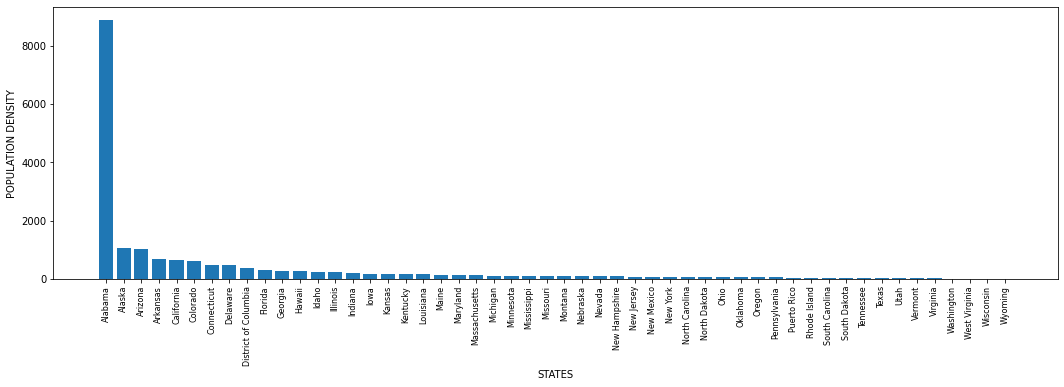

In [109]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(18,5))
state =[state for state, df in data2010.groupby('state')] 
plt.bar(state, density)
plt.xticks(state, rotation ='vertical', size =8)
plt.ylabel('POPULATION DENSITY')
plt.xlabel('STATES')
plt.show()